<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v4_aside1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v4 - Aside 1
This notebook looks at the loss and gradient oscillations in an extremely simple optimization problem:
$$cost = w ^ 2 - 10w + 25$$

This has a very simple solution with
$$cost = 0 \rightarrow w = 5$$

But we'll find that through gradient descent, using a few different optimizers, and look at what oscillations crop-up.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [15]:
def train_step(w, optimizer):
    with tf.GradientTape() as tape:
      cost = w ** 2 - 10 * w + 25
    trainable_variables = [w]
    grads = tape.gradient(cost, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return cost, grads

def train(w, optimizer, num_iterations = 1000):
  loss_list = []
  grad_list = []
  for i in range(num_iterations):
    cost, grads = train_step(w, optimizer)
    loss_list.append(cost)
    grad_list.append(grads)
  return np.array(loss_list), np.array(grad_list)

def plot_history(losses, grads):
  plt.figure(layout='constrained')

  plt.subplot(2,2,1)
  plt.plot(losses, label='loss')
  plt.legend()

  plt.subplot(2,2,2)
  plt.plot(grads, label='gradient')
  plt.legend()

  plt.subplot(2,2,3)
  plt.plot(losses, label='loss')
  plt.yscale('log')
  plt.legend()

  plt.subplot(2,2,4)
  plt.plot(np.abs(grads), label='abs(gradient)')
  plt.yscale('log')
  plt.legend()

  plt.show()

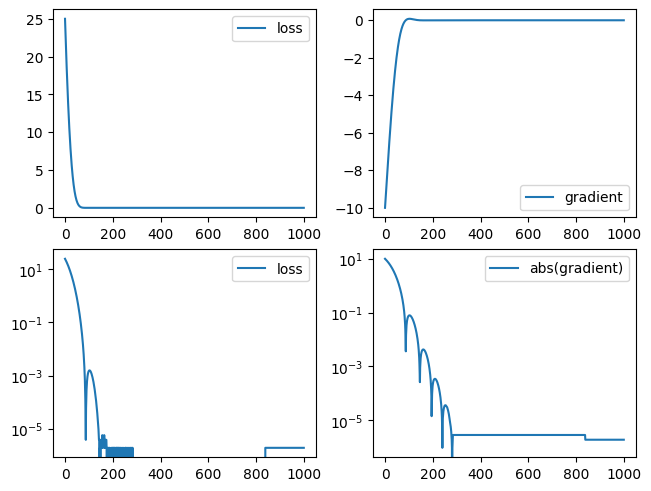

In [16]:
w = tf.Variable(0, dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(0.1)
losses, grads = train(w, optimizer)
plot_history(losses, grads)

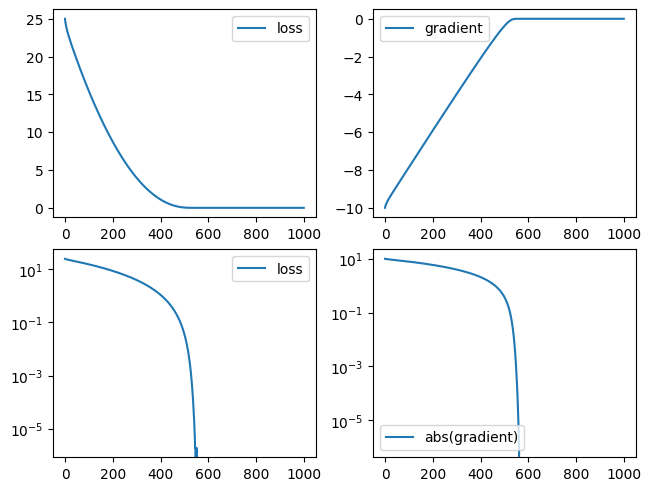

In [19]:
w = tf.Variable(0, dtype=tf.float32)
optimizer = tf.keras.optimizers.RMSprop(0.01)
losses, grads = train(w, optimizer)
plot_history(losses, grads)

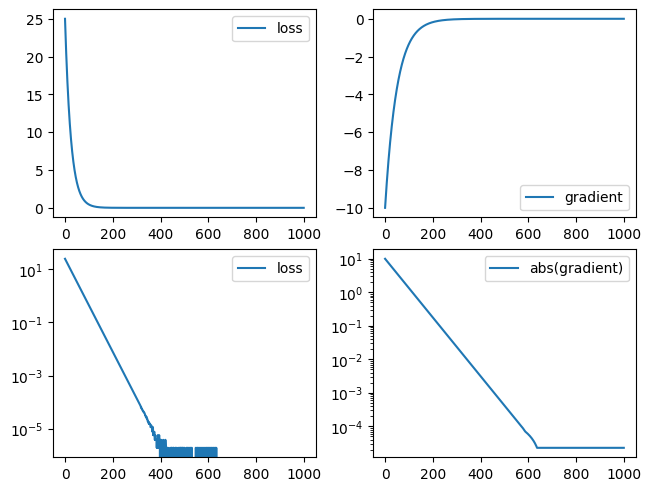

In [17]:
w = tf.Variable(0, dtype=tf.float32)
optimizer = tf.keras.optimizers.SGD(0.01)
losses, grads = train(w, optimizer)
plot_history(losses, grads)

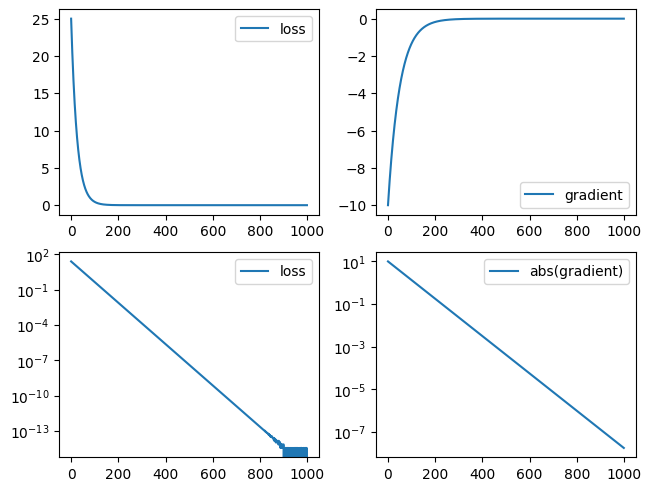

In [20]:
w = tf.Variable(0, dtype=tf.float64)
optimizer = tf.keras.optimizers.SGD(0.01)
losses, grads = train(w, optimizer)
plot_history(losses, grads)

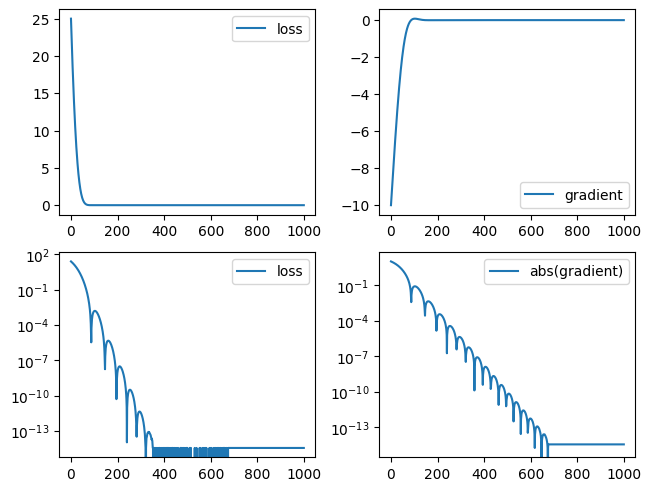

In [21]:
w = tf.Variable(0, dtype=tf.float64)
optimizer = tf.keras.optimizers.Adam(0.1)
losses, grads = train(w, optimizer)
plot_history(losses, grads)

## Findings
The Adam optimizer is regularly preferred for its leniency. It's less susceptible to different hyperparameters, making it easier to get a working model. But it's internal complexity comes out in the form of oscillations that we see.

### Floating Point precision as cause for oscillations
While simple SGD only produces oscillations in this extremely simple problem when it is close to the target, the Adam optimizer leads to oscillations throughout the learning curve. In fact, for this simple problem, SGD only produces oscillations once it starts to run into numerical accuracy problems. We see this by the way that with float32, SGD starts to experience oscillations in the loss once it reaches a loss on the order of $10^{-5}$, however once we switch to use of float64, we get a stable and smooth loss curve all the way down to the order of $10^{-13}$, and a completely smooth gradient for the duration of the training.

In contrast, Adam produces oscillations with the gradients on the order of $10^{-1}$ and the loss on the order of $10^{-2}$.

In fact, the most telling plot is the log-abs-gradient plot using the Adam optimizer with a float64 variable. The shape of the gradient curve is clearly impacted by factors other than floating point precision.

_Conclusion: no a significant impact._

### Too large learning rate as cause for oscillations
In neural networks, SGD is prone for oscillations, and needs a very low learning rate to prevent it. Even when prevented, it will still tend to oscillate around the target once it gets close, and needs a the learning rate to be gradually reduced in order to achieve convergence.

However, for this simple example, SGD doesn't experience any oscillations due to this effect. That's because the gradient itself naturally acts in such a way as to reduce the learning rate over time. This can be seen most clearly in the way that any oscillations that are present on the SGD learning curves are pushed to much lower values when switching from float32 to float64.

_Conclusion: no impact._

### Harmonics and cause for oscillations
If the monotonically reducing gradient is sufficient to converge the learning rate towards zero, and is sufficient to prevent oscillations, why does the Adam optimizer learning curve experience oscillations?

I believe the answer lies in _harmonics_ induced by mixing different _frequencies_.

The learning rate parameter, in conjunction with the rate of monotonically decreasing gradients, has the effect of a signal dampener with a particular decay rate. In a loose sense, that decay rate can be thought of as a frequency.

Adam includes two other components with similar characteristics. It's first and second moment calculations. Both of these alse apply a dampening or amplification to the gradient signal, depending on the recent learning trajectory. The $\beta$ factors that control the relative effect of the first and second moments, respectively, act as additional frequencies.

Thus we have three dampending and/or amplication components, with different frequencies. The harmonics produced by that mixing of frequencies is what causes the oscillations.

To put it more simple, consider the curve produced by the learning rate and reducing gradients. The learning rate causes the system to move along the gradients at a particular rate, and thus for the gradients to reduce at a particular rate. Separately, the first moment of the gradients is computed by the Adam optimizer, but is filtered through an exponentially weigthed moving average with a $\beta$ factor that controls the relative importance of the current gradient versus all the previous gradients - acting as a sort of memory or hysterisis. If the dampening from learning_rate + gradient reduction is faster than the first moment hysterisis, then the Adam algorithm will give an extra push to the trajectory through parameter space, potentially causing it to overshoot.

In fact, if the learning rate, and the two Adam optimizer $\beta$s were perfectly tuned, you wouldn't get the oscillation. But that is extremely difficult to achieve.

_Conclusion: oscillations are caused by the harmonics that emerge from the different inherent frequencies from the learning rate, the first moment $\beta_1$, and the second moment $\beta_2$. Furthermore, such oscillations are here to stay as it's too hard to tune them away._

